In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import clear_output

In [3]:
from scipy.sparse import *
from scipy.sparse.linalg import eigsh

def tensor(ops):
    to_ret = ops[0]
    for op in ops[1:]:
        to_ret = kron(to_ret, op)
    return to_ret

def tensor_op(ops_to_insert, dim):
    ops_total = tensor([diags(ones(N))]*dim)
    
    for key in ops_to_insert:
        ops_total[key] = ops_to_insert[key]
    return tensor(ops_total)

In [4]:
def d(N, h, periodic = False):
    coeffs = [-1/60, 3/20, -3/4, 0, 3/4, -3/20, 1/60 ]
    
    d = sum([coeffs[i+3]*diag(ones(N-abs(i)), i)/h for i in range(-3, 4)], axis=0)
    
    if periodic:
        for i in range(-4, 4):
            d[i, :] = roll(d[i-1,:], 1)
        
    return d
    
def d2(N, h, periodic = False):
    coeffs = [1/90, -3/20, 3/2, -49/18, 3/2, -3/20, 1/90]
    
    d2 = sum([coeffs[i+3]*diag(ones(N-abs(i)), i)/h**2 for i in range(-3, 4)], axis=0)
    if periodic:
        for i in range(-4, 4):
            d2[i, :] = roll(d2[i-1,:], 1)
        
    return d2

def identity(N):
    return diags(ones(N))

## Planck oscillator

Hamiltonian:

$$H =  -\frac{1}{2L}\frac{\partial^2}{\partial Q^2} + \frac{Q^2}{2C}$$

In [4]:
C = 1
L = 1

In [5]:
N = 100
Qs = linspace(-4, 4, N)
h_Q = Qs[1]-Qs[0]

def d2(N, h):
    coeffs = [-1/12, 4/3, -5/2, 4/3, -1/12]
    
    d2 = sum([coeffs[i+2]*diag(ones(N-abs(i)), i)/h**2 for i in range(-2, 3)], axis=0)
    
#     for i in range(-4, 4):
#         d2[i, :] = roll(d2[i-1,:], 1)
        
    return d2

In [6]:
def H():
    return -1/2/L*d2(N, h_Q) + 1/2/C*diag(Qs)**2

In [7]:
evals, evecs = linalg.eigh(H())
evecs[:,0] = -evecs[:, 0]

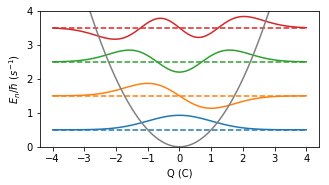

In [8]:
for i in range(0,4):
    plot(Qs, evecs[:,i]*2+evals[i], "C%i"%i)
    plot(Qs, ones_like(Qs)*evals[i], "C%i--"%i)

plot(Qs, Qs**2/2/C,"-", color='gray')
plt.ylim(0, 4)
gcf().set_size_inches(5, 2.5)
ylabel("$E_n/\hbar\ (s^{-1})$")
xlabel("Q (С)")
plt.savefig("/home/gleb/Документы/Science/PhD thesis/Pictures/planck_oscillator.pdf", bbox_inches="tight")

##### L||L||C

Hamiltonian:
    $$\frac{\partial^2}{\partial \phi_1^2}\frac{1}{2C} + \frac{\left(\phi_1 + \Phi_e^{(1)}\right)^2}{2L_r^{(1)}} +\frac{\left(\phi_1 + \Phi_e^{(2)}\right)^2}{2 L_r^{(2)}}$$

In [9]:
phi1s = linspace(-pi, pi)
L1 = 0.3
L2 = 0.7
Phi_e1 = 1
Phi_e2 = -2

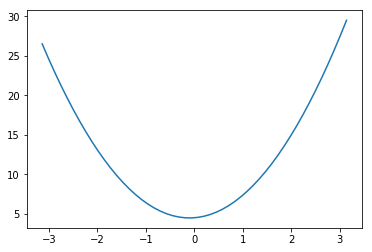

In [10]:
plot(phi1s, (phi1s + Phi_e1)**2/2/L1 + (phi1s + Phi_e2)**2/2/L2)

##### LL||C

Hamiltonian:
    $$\mathcal{L}_{L||L||C} = \frac{1}{2C}\frac{\partial^2}{\partial \phi_1^2} + \frac{(\phi_2 - \phi_1)^2}{2L_r^{(1)}} + \frac{\left(\phi_2+\Phi_e\right)^2}{2 L_r^{(2)}}.$$

In [46]:
N1 = 51
N2 = 51
L1 = L2 = .5
C = 1
phi1s = linspace(-2*pi, 2*pi, N1)
h_phi1 = phi1s[1]-phi1s[0]
phi2s = linspace(-pi, pi, N2)*3
h_phi2 = phi2s[1] - phi2s[0]

In [47]:
PHI1, PHI2 = meshgrid(phi1s, phi2s)

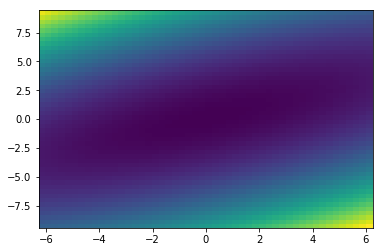

In [48]:
pcolormesh(PHI1, PHI2, (PHI1 - PHI2)**2/2/L1 + PHI2**2/2/L2)

In [49]:
def d2(N, h):
    coeffs = [-1/12, 4/3, -5/2, 4/3, -1/12]
    
    d2 = sum([coeffs[i+2]*diags(ones(N-abs(i)), i)/h**2 for i in range(-2, 3)], axis=0)
    
#     for i in range(-4, 4):
#         d2[i, :] = roll(d2[i-1,:], 1)
        
    return d2

In [61]:
def tensor(*ops):
    to_ret = ops[0]
    for op in ops[1:]:
        to_ret = kron(to_ret, op)
    return to_ret
def identity(N):
    return diags(ones(N))

In [62]:
from scipy.sparse import kron

In [63]:
def H(Phi_e, C_factor):
    return -tensor(d2(N1,h_phi1)/2/C, identity(N2)) - tensor(identity(N1), d2(N2,h_phi1)/2/C*C_factor) \
            + (tensor(diags(phi1s), identity(N2)) - tensor(identity(N1), diags(phi2s)))**2/2/L1 \
            + (tensor(identity(N1), diags(phi2s+Phi_e)))**2/2/L2

In [64]:
evals_delta, evecs_delta = eigsh(H(0, 0), k=10, which="SA")
evals, evecs = eigsh(H(0, 100), k=10, which="SA")

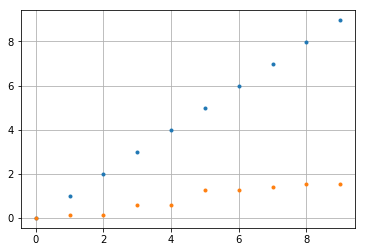

In [66]:
plot(evals-evals[0], ".")
plot((evals_delta-evals_delta[0]), ".")
grid()

Text(-0.7, 1.05, '(b)')

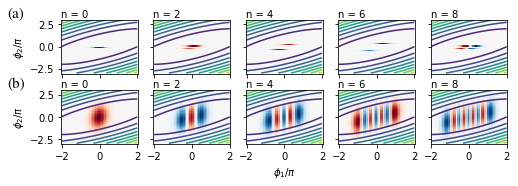

In [67]:
X = concatenate((phi1s - h_phi1/2, [phi1s[-1]+h_phi1/2]))
Y = concatenate((phi2s - h_phi2/2, [phi2s[-1]+h_phi2/2]))
fig, axes = plt.subplots(2,5, sharey=True)

evecs_plot = [evecs_delta, evecs]

for i in range(2):
    for j in range(5):    
        data = evecs_plot[i][:,2*j].reshape(N1, -1).T 
        axes[i, j].contour(PHI1/pi, PHI2/pi, (PHI1 - PHI2)**2/2/L1 + PHI2**2/2/L2, 10)
        axes[i, j].pcolormesh(X/pi, Y/pi, data, cmap="RdBu_r", vmin=-np.max(abs(data)), vmax = np.max(abs(data)), rasterized = True)
        axes[i,j].text(0, 1.05, f"n = {j*2}", transform=axes[i,j].transAxes)
        if i == 0:
            axes[i,j].set_xticklabels([])
gcf().set_size_inches(8,8/3.5)
axes[1][2].set_xlabel("$\phi_1/\pi$")
axes[0][0].set_ylabel("$\phi_2/\pi$")
axes[1][0].set_ylabel("$\phi_2/\pi$")

plt.subplots_adjust(hspace=.3)

plt.text(-.7, 1.05, "(a)", fontdict={"name": "STIX"}, fontsize=15,
         transform=axes[0,0].transAxes)
plt.text(-.7, 1.05, "(b)", fontdict={"name": "STIX"}, fontsize=15,
         transform=axes[1,0].transAxes)
# plt.savefig("/home/gleb/Документы/Science/PhD thesis/Pictures/llc_states.pdf", bbox_inches="tight", dpi=300)

##### LCg

Hamiltonitan:
$$\mathcal{H}_{LCg} = \frac{1}{2} \left(\begin{matrix} q_1\\q_2\end{matrix}\right) \left(\begin{matrix}
	C+C_r & -C_r \\
	-C_r & C+C_r
	\end{matrix}\right)^{-1}\left(\begin{matrix} q_1&q_2\end{matrix}\right)+\frac{L_r \left(\phi_1  - \phi_2\right)^2}{2}.$$

In [400]:
C = 0.01
C_r = 1
L_r = 1
L = 10
N1, N2 = 151, 151
phi1s = linspace(-2*pi, 2*pi, N1)*2
h_phi1 = phi1s[1]-phi1s[0]
phi2s = linspace(-2*pi, 2*pi, N2)*2
h_phi2 = phi2s[1] - phi2s[0]

In [401]:
def Hc():
    charge_matrix = matrix([[C+C_r, -C_r], [-C_r, C+C_r]])
    inv_charge_matrix = inv(charge_matrix)
    periodic = False
    ds = tensor([d(N1,h_phi1, periodic=periodic),identity(N2)]), \
         tensor([identity(N1), d(N2,h_phi2, periodic=periodic)])
        
    d2s = tensor([d2(N1,h_phi1, periodic=periodic),identity(N2)]), \
          tensor([identity(N1), d2(N2,h_phi2, periodic=periodic)])
    
    Hc = tensor([diags(zeros(N1)), diags(zeros(N2))])
        
    for i in range(0,2):
        for j in range(0,2):
            if i == j:
                Hc += -0.5*inv_charge_matrix[i,j]*d2s[i]
            else:
                Hc += -0.5*ds[i]*inv_charge_matrix[i,j]*ds[j]
    return Hc

def Hj():
    L_mat = array([[1/L+1/L_r, -1/L_r], 
                  [-1/L_r, 1/L+1/L_r]])
    
    phis = tensor([diags(phi1s),identity(N2)]),\
           tensor([identity(N1), diags(phi2s)])
    Hj = tensor([diags(zeros(N1)), diags(zeros(N2))])
    for i in range(2):
        for j in range(2):
            Hj += 0.5*L_mat[i,j]*phis[i]*phis[j]
    return Hj

def H():
    return Hc() + Hj()

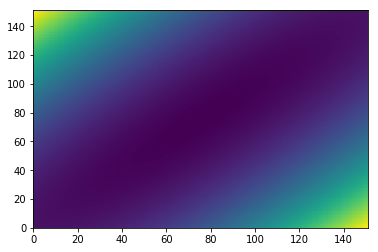

In [402]:
pcolormesh(Hj().diagonal().reshape(N1, -1))

In [403]:
evals, evecs = eigsh(H(), which="SA", k=5)

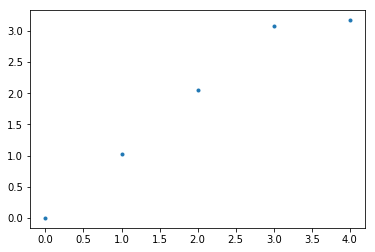

In [404]:
plot(evals - evals[0], ".")

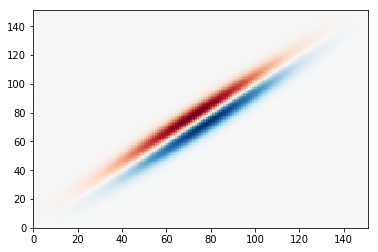

In [405]:
data = evecs[:, 1].reshape(N1, -1).T
pcolormesh(data, cmap="RdBu_r", vmin=-np.max(abs(data)), vmax = np.max(abs(data)))
# gcf().set_size_inches(15,15)

## Phase qubit

Hamiltonian:

$$H =  - 4 E_C \frac{\partial^2}{\partial \phi^2} - E_J \cos\phi + E_L (\phi - \phi_{ext})^2$$

In [25]:
N = 51
Ec = 20
Ej = 50
El = 10
periodic = False

phis = linspace(-pi, 3*pi, N)
h_phi = phis[1]-phis[0]
diff_oper = (diag(ones(N-1), -1)-2*eye(N)+diag(ones(N-1), 1))/h_phi**2
if periodic:
    diff_oper[0,-1] = diff_oper[0,1]
    diff_oper[-1,0] = diff_oper[-1,-2]

In [26]:
def H(phi_ext):
    return -Ec * diff_oper - Ej*diag(cos(phis)) + El*diag((phis-2*pi*phi_ext)**2)

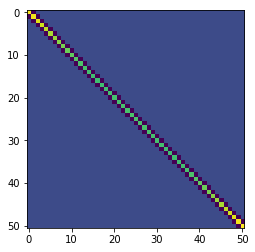

In [27]:
imshow(H(0.5))

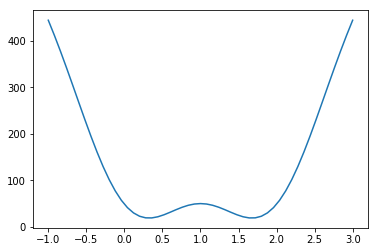

In [28]:
plot(phis/pi, -Ej*cos(phis)+El*(phis-2*pi*0.5)**2)

In [29]:
evals, evecs = linalg.eigh(H(0.5))
evals1 = evals

(0, 100)

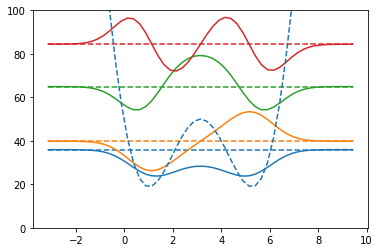

In [35]:
for i in range(0,4):
    plot(phis, evecs[:,i]*50+evals[i], "C%i"%i)
    plot(phis, ones_like(phis)*evals[i], "C%i--"%i)

plot(phis, -Ej*cos(phis)+El*(phis-2*pi*0.5)**2,"--")
plt.ylim(0, 100)

## Flux qubit

In [110]:
Ec = 24
Ej = 100
alpha = 0.65
phi_ext = 0.5

N1 = 7
N2 = 7

phi1s = linspace(-pi, pi, N1, endpoint=False)
phi2s = linspace(-pi, pi, N2, endpoint=False)

h_phi1 = phi1s[1]-phi1s[0]
h_phi2 = phi2s[1]-phi2s[0]

In [111]:
def Hc():

    charge_matrix = array([[2/Ec, -1/Ec], [-1/Ec, 1/Ec+alpha/Ec]])
    inv_charge_matrix = inv(charge_matrix)
    
    ds = tensor([d(N1,h_phi1),identity(N2)]), \
         tensor([identity(N1), d(N2,h_phi2)])
        
    d2s = tensor([d2(N1,h_phi1),identity(N2)]), \
          tensor([identity(N1), d2(N2,h_phi2)])
    
    Hc = tensor([diags(zeros(N1)), diags(zeros(N2))])
    for i in range(0,2):
        for j in range(0,2):
            if i == j:
                Hc += -0.5*inv_charge_matrix[i,j]*d2s[i]
            else:
                Hc += -0.5*ds[i]*inv_charge_matrix[i,j]*ds[j]
    return Hc

def Hj():
    Ejs = [Ej, Ej, alpha*Ej]
    
    ops = (tensor([diags(phi1s), identity(N2)])), \
              (tensor([identity(N1), diags(phi2s)]) - tensor([diags(phi1s), identity(N2)])),\
              (tensor([identity(N1), diags(phi2s)]) - phi_ext*2*pi*tensor([identity(N1), identity(N2)]))
    cos_ops = []
    for op in ops:
        cos_ops.append(diags(cos(op.diagonal())))
    
    return -sum([Ejs*cos_ops for Ejs, cos_ops in zip(Ejs, cos_ops)])

def H():
    return Hc()+Hj()

In [112]:
tensor([identity(N1), diags(phi2s)]).shape, tensor([diags(phi1s), identity(N2)]).shape

((49, 49), (49, 49))

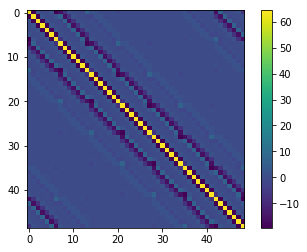

In [113]:
figure()
imshow(Hc().toarray())
colorbar()
# plt.gcf().set_size_inches(10,10)

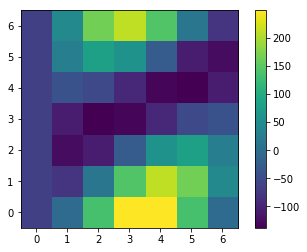

In [114]:
imshow(diagonal(Hj().toarray()).reshape(N1,-1), origin="lower")
colorbar()
# gcf().set_size_inches(15,15)

In [134]:
# %%time
N1 = 100
N2 = 100

phi1s = linspace(-pi, pi, N1, endpoint=False)
phi2s = linspace(-pi, pi, N2, endpoint=False)

h_phi1 = phi1s[1]-phi1s[0]
h_phi2 = phi2s[1]-phi2s[0]

phi_ext = 0.5
evals, evecs = eigsh(H(), sigma=-100, k=10)
evals

array([-113.13821144, -106.93643907,  -90.95543089,  -74.02074396,
        -71.9396815 ,  -69.91821232,  -56.36567983,  -52.76295141,
        -44.72421805,  -40.79475449])

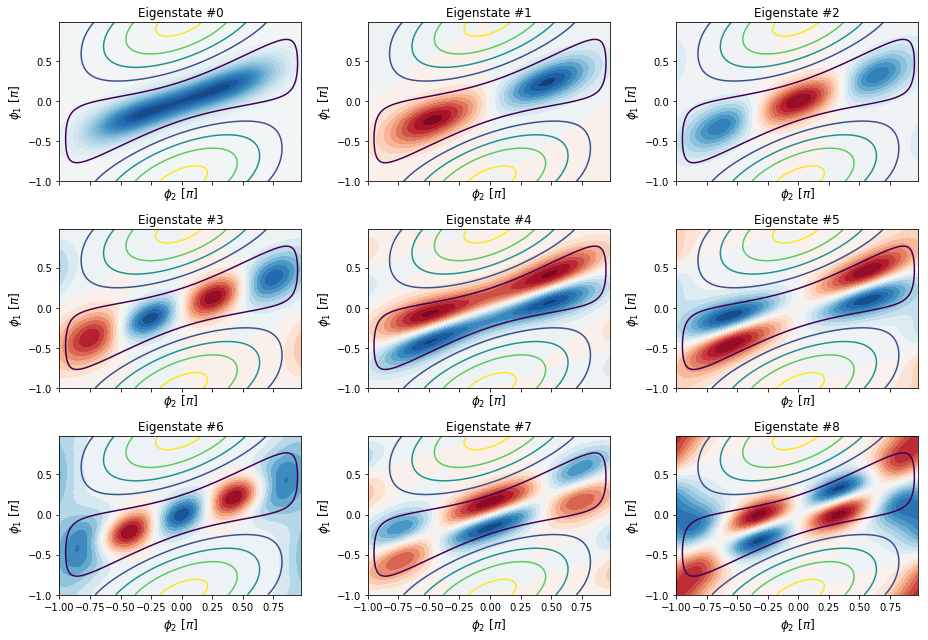

In [139]:
fig, axes_arr = plt.subplots(3,3, figsize=(13,9), sharex=True)
axes_arr = axes_arr.ravel()
for idx, evec in enumerate(evecs.T[:9]):
#     axes = axes_arr[idx]
    axes_arr[idx].clear()
#     axes[1].clear()
    norm = max(abs(evec))
    m_potential = axes_arr[idx].contour(phi2s/pi, phi1s/pi, diagonal(Hj().toarray()).reshape(N1,-1), 5)
    m = axes_arr[idx].contourf(phi2s/pi, phi1s/pi, reshape(evec, (N1,-1)), 20, cmap="RdBu_r", vmax=norm*1.1, vmin=-norm*1.1)
#     colorbar(m_potential, ax=axes[0],shrink=0.8)
#     colorbar(m, ax=axes[0], orientation="horizontal")


    axes_arr[idx].set_title("Eigenstate #%i"%idx)
    axes_arr[idx].set_ylabel("$\phi_1$ [$\pi$]", fontsize=12)
    axes_arr[idx].set_xlabel("$\phi_2$ [$\pi$]", fontsize=12)

#     axes[1].plot(range(0, idx+1), evals[:idx+1]-evals[0], marker="o")
#     axes[1].set_xlabel("State #")
#     axes[1].set_ylabel("Energy [GHz]") 
#     axes[1].grid()
#     plt.savefig("Level: "+str(idx)+".png")
#     plt.pause(0.01)
    clear_output()
tight_layout()

In [123]:
def plot_einenergies(engs,fs, legend=True, alpha = 1):
    for idx in range(1,engs.shape[1]):
        plt.plot(fs,engs[:,idx]-engs[:,0], label=r'$E_{%s}-E_{%s}$'%(idx,0), color="C%i"%(idx-1), alpha = alpha)
    
    flux_idx = len(fs)//2
    print("Energies at sweet spot:", around(engs[flux_idx,1]-engs[flux_idx,0], 2),
                                     around(engs[flux_idx,2]-engs[flux_idx,0], 2),
                                     around(engs[flux_idx,3]-engs[flux_idx,0], 2),
                                     around(engs[flux_idx,4]-engs[flux_idx,0], 2)) 

    if legend:
        plt.legend()
    plt.grid()

In [121]:
phi_exts = linspace(.4, .6, 51)

solutions = []
for N1, N2 in zip(range(5,11,1), range(5,11,1)):
    print("\nDimensions:", "%dx%d"%(N1,N2), flush=True)
    
    phi1s = linspace(-pi, pi, N1, endpoint=False)
    phi2s = linspace(-pi, pi, N2, endpoint=False)

    h_phi1 = phi1s[1]-phi1s[0]
    h_phi2 = phi2s[1]-phi2s[0]
    
    ergs = []
    for phi_ext in phi_exts:
        evals, evecs = eigsh(H(), which="SA", k=10)
        ergs.append(evals-evals[0])
        print("\rFlux: %.2f"%phi_ext, end="", flush=True)
    solutions.append(ergs)


Dimensions: 5x5
Flux: 0.60
Dimensions: 6x6
Flux: 0.60
Dimensions: 7x7
Flux: 0.60
Dimensions: 8x8
Flux: 0.60
Dimensions: 9x9
Flux: 0.60
Dimensions: 10x10
Flux: 0.60

Energies at sweet spot: 7.14 10.79 17.96 44.84
Energies at sweet spot: 9.32 17.37 37.92 44.06
Energies at sweet spot: 5.67 22.61 34.52 42.04
Energies at sweet spot: 6.05 21.55 39.63 43.97
Energies at sweet spot: 6.17 22.25 38.67 43.13
Energies at sweet spot: 6.18 22.25 39.24 42.77


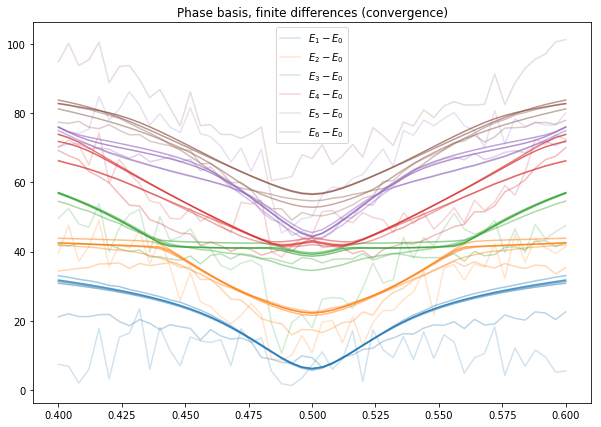

In [131]:
for idx, ergs in enumerate(solutions):
    plot_einenergies(array(ergs)[:,:7], phi_exts, False, 0.2+0.1*idx)
plt.title("Phase basis, finite differences (convergence)")
plt.legend()
plt.gcf().set_size_inches(10,7)

### Hydrogen atom (needs high processing power)

In [291]:
from scipy.constants import epsilon_0, e, m_e, hbar
from scipy.sparse.linalg import inv

The Hamiltonian: $$ H = -\frac{\hbar^2}{2m} \nabla^2 + \frac{e^2}{4\pi\epsilon_0 r}$$

In [397]:
N = 151
xs = linspace(-10e-10, 10.0001e-10, N)*2
ys = linspace(-10e-10, 10.0001e-10, N)*2
zs = linspace(-10e-10, 10.0001e-10, N)*2

    
x_op = tensor([diags(xs), identity(N), identity(N)])
y_op = tensor([identity(N), diags(ys), identity(N)])
z_op = tensor([identity(N), identity(N), diags(zs)])

# xs = linspace(-5, 5, N)*2
# ys = linspace(-5, 5, N)*2
# zs = linspace(-5, 5, N)*2

h_x = diff(xs)[0]
h_y = diff(ys)[0]
h_z = diff(zs)[0]

p2x = -hbar**2*tensor([d2(N, h_x), identity(N), identity(N)])
p2y = -hbar**2*tensor([identity(N), d2(N, h_y), identity(N)])
p2z = -hbar**2*tensor([identity(N), identity(N), d2(N, h_z)])


# p2x = -tensor([d2(N, h_x), identity(N), identity(N)])
# p2y = -tensor([identity(N), d2(N, h_y), identity(N)])
# p2z = -tensor([identity(N), identity(N), d2(N, h_z)])


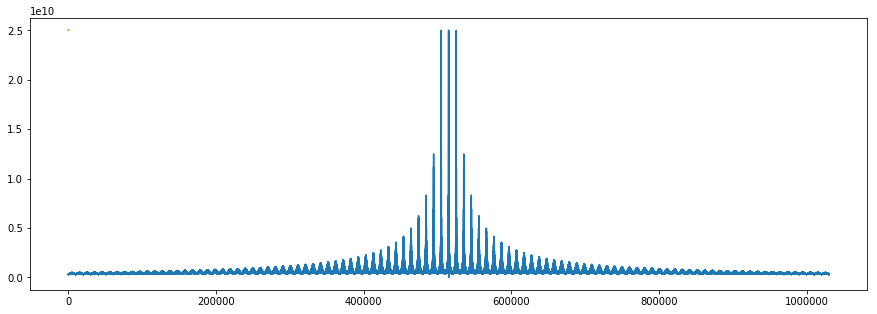

In [392]:
inv_r_op = (1/(sqrt(x_op**2 + y_op**2 + z_op**2).diagonal()))
inv_r_op[inv_r_op>5/h_x] = 0


plot((inv_r_op))
plot(ones(1000)/h_x)
gcf().set_size_inches(15,5)

In [393]:
def H_hyd():

    inv_r_op = (1/(sqrt(x_op**2 + y_op**2 + z_op**2).diagonal()))
    inv_r_op[inv_r_op>5/h_x] = 0
    inv_r_op = diags(inv_r_op)
    
#     return (p2x+p2y+p2z)/2 - r_op
    return (p2x+p2y+p2z)/2/m_e - e**2/4/pi/epsilon_0*inv_r_op

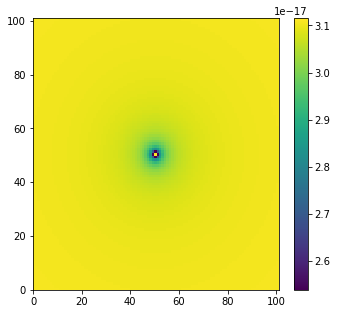

In [394]:
pcolormesh(H_hyd().diagonal().reshape(N, N, N)[N//2])#, vmin = -1.2e-17, vmax = -.1e-17)
colorbar()
gcf().set_size_inches(5.5,5)

In [395]:
evals, evecs = eigsh(H_hyd(), k=15, which="SA")

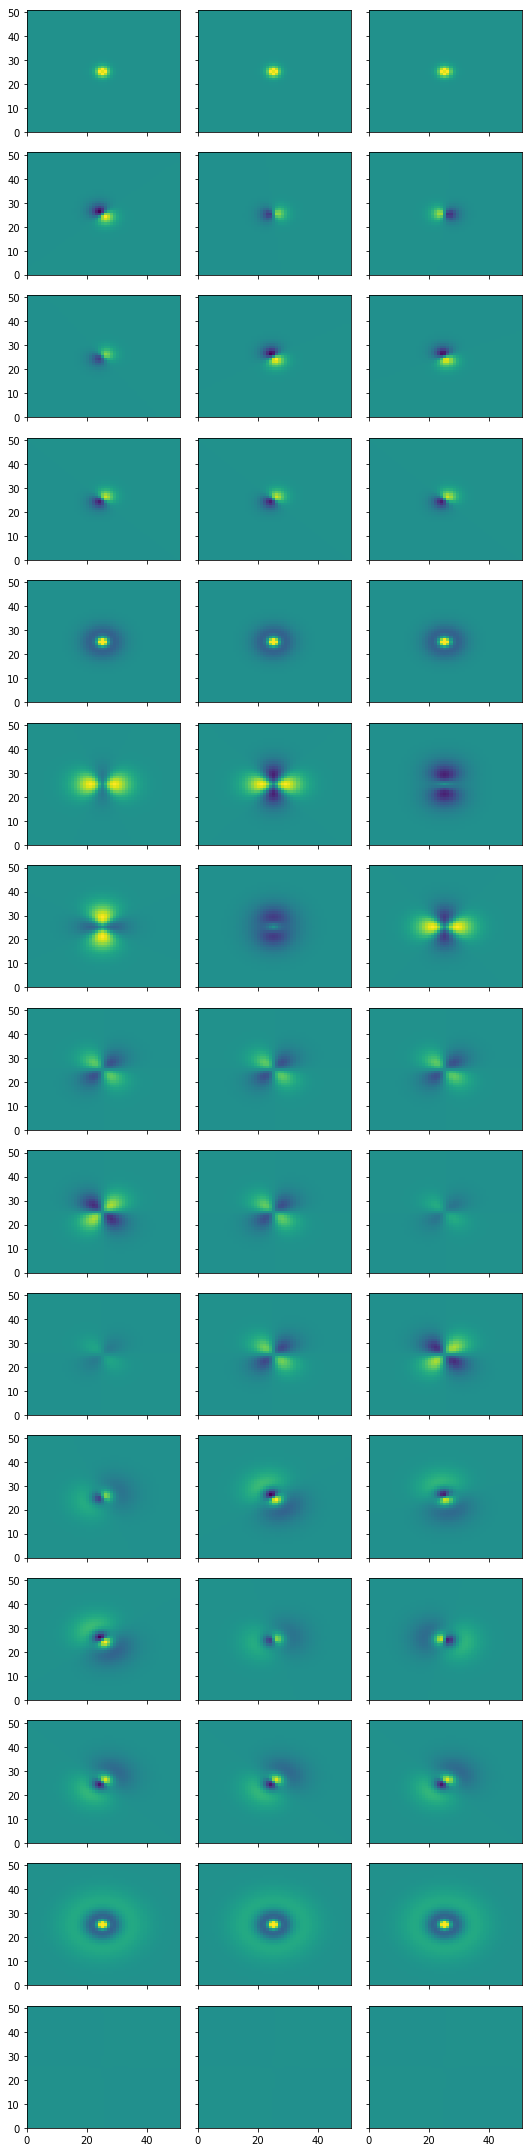

In [389]:
fig, axes = plt.subplots(15,3, sharex = True, sharey = True)
for state_id in range(15):
    
    state = evecs[:,state_id]
    
    axes[state_id, 0].pcolormesh(state.reshape(N, N, N)[N//2,:, :], vmin  = -max(abs(state)), vmax =  max(abs(state)))
    axes[state_id, 1].pcolormesh(state.reshape(N, N, N)[:, N//2, :], vmin  = -max(abs(state)), vmax =  max(abs(state)))
    axes[state_id, 2].pcolormesh(state.reshape(N, N, N)[:, :, N//2], vmin = -max(abs(state)), vmax =  max(abs(state)))
#     axes[state_id, 0].plot(state.reshape(N, N, N)[N//2,N//2, :])
    # colorbar()
gcf().set_size_inches(7.5,30)
tight_layout()